In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy

import seaborn as sns

import plot_court
import sklearn.model_selection
import pymc3 as pm


sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)

C:\Users\Geoff\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Data is from https://github.com/hwchase17/sportvu

In [2]:
full_DatFrame = pd.read_csv('../dat/joined_shots_2013.csv')
full_DatFrame[:3]

,Unnamed: 0,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID,GAME_ID.1,...,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,0,"Turner, Evan",202323.0,1.9,17.0,0.0,10.0,8:09,21300165,21300165,...,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6.0,-40.0,53.0,1.0,0.0
1,1,"Turner, Evan",202323.0,3.2,0.0,1.0,10.0,9:10,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,182.0,195.0,1.0,1.0
2,2,"Carter-Williams, Michael",203487.0,3.5,0.0,0.0,10.0,8:36,21300165,21300165,...,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,159.0,206.0,1.0,0.0


In [3]:
full_DatFrame.keys()

Index(['Unnamed: 0', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID',
       'CLOSE_DEF_DIST', 'DRIBBLES', 'FGM', 'FINAL_MARGIN', 'GAME_CLOCK',
       'GAME_ID', 'GAME_ID.1', 'LOCATION', 'MATCHUP', 'PERIOD', 'PERIOD.1',
       'PTS', 'PTS_TYPE', 'SHOT_CLOCK', 'SHOT_DIST', 'SHOT_NUMBER',
       'SHOT_RESULT', 'TOUCH_TIME', 'W', 'GRID_TYPE', 'GAME_EVENT_ID',
       'PLAYER_ID', 'PLAYER_ID.1', 'PLAYER_NAME', 'TEAM_ID',
       'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE',
       'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE',
       'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG',
       'SHOT_MADE_FLAG'],
      dtype='object')

In [4]:
df = pd.DataFrame(full_DatFrame, 
                  columns = ['PLAYER_ID.1', 'PLAYER_NAME', 
                             'MATCHUP', 'LOCATION', 'TEAM_ID', 
                             'SHOT_DISTANCE', 
                             'PTS_TYPE', 'LOC_X', 'LOC_Y', 
                             'ACTION_TYPE', 'SHOT_TYPE',
                             'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG'])
df[:3]

,PLAYER_ID.1,PLAYER_NAME,MATCHUP,LOCATION,TEAM_ID,SHOT_DISTANCE,PTS_TYPE,LOC_X,LOC_Y,ACTION_TYPE,SHOT_TYPE,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,6.0,2.0,-40.0,53.0,Jump Shot,2PT Field Goal,1.0,0.0
1,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,182.0,195.0,Jump Shot,3PT Field Goal,1.0,1.0
2,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,159.0,206.0,Jump Shot,3PT Field Goal,1.0,0.0


In [5]:
teamID_dict = plot_court.out_teamsDict()

In [6]:
plot_court.out_teamsDict(team_abbrev='ORL')['teamId']

1610612753

In [7]:
def out_teamAbbrev(teamID):
    teamID_dict = plot_court.out_teamsDict()
    return teamID_dict[teamID]['abbreviation']

df['TEAM_ABBREV'] = pd.Series(map(out_teamAbbrev, df.TEAM_ID), index=df.index)
df[:3]

,PLAYER_ID.1,PLAYER_NAME,MATCHUP,LOCATION,TEAM_ID,SHOT_DISTANCE,PTS_TYPE,LOC_X,LOC_Y,ACTION_TYPE,SHOT_TYPE,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,TEAM_ABBREV
0,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,6.0,2.0,-40.0,53.0,Jump Shot,2PT Field Goal,1.0,0.0,TOR
1,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,182.0,195.0,Jump Shot,3PT Field Goal,1.0,1.0,TOR
2,202779,Dwight Buycks,"NOV 20, 2013 - TOR @ PHI",A,1.610613e+09,26.0,3.0,159.0,206.0,Jump Shot,3PT Field Goal,1.0,0.0,TOR


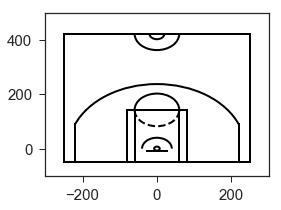

In [8]:
plt.figure(figsize=(4,3))
plot_court.draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

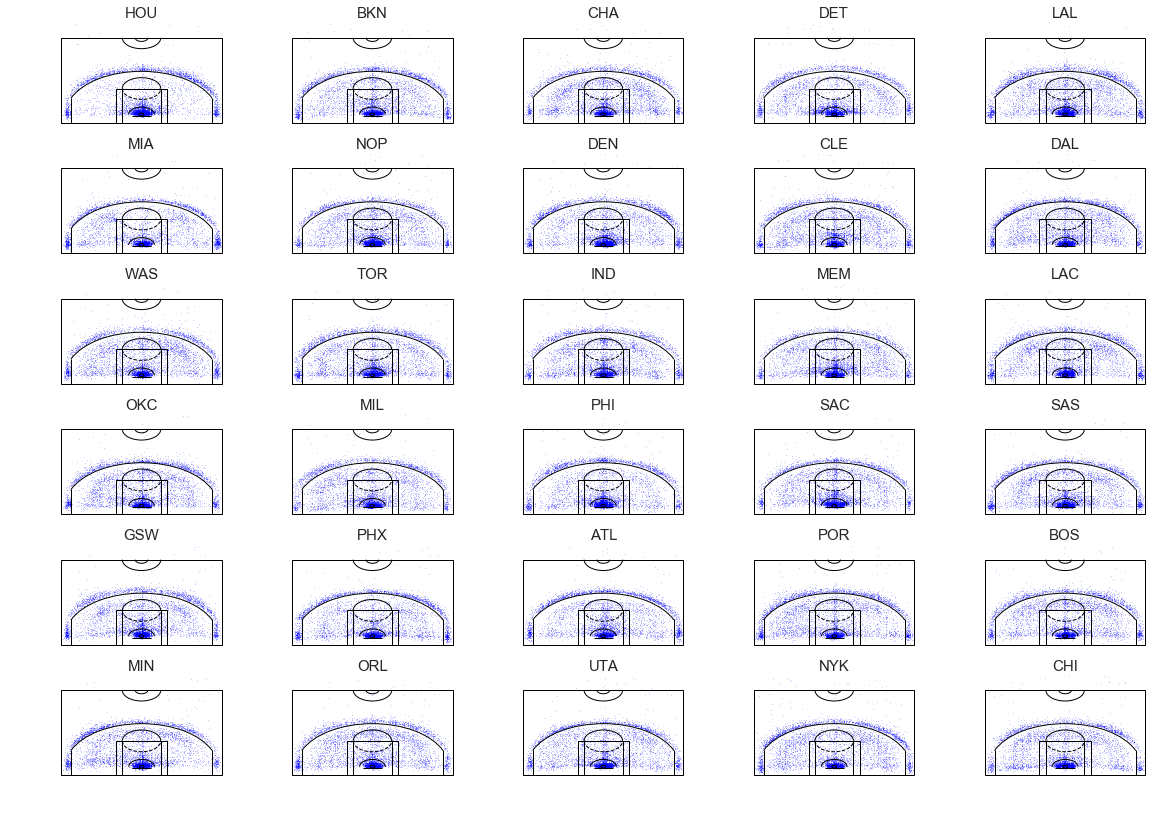

In [9]:
plt.figure(figsize=(20,14))
for i, team_abbrev in enumerate(set(df.TEAM_ABBREV)):
    plt.subplot(6, 5, i+1)
    plot_court.draw_court(outer_lines=True, lw=1.)
    
    temp = df[df.TEAM_ABBREV == team_abbrev]
    plt.scatter(temp.LOC_X, temp.LOC_Y, s=0.1, c='blue', alpha=0.5)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s'%(team_abbrev), fontsize=15)
    plt.axis('off')
plt.show()

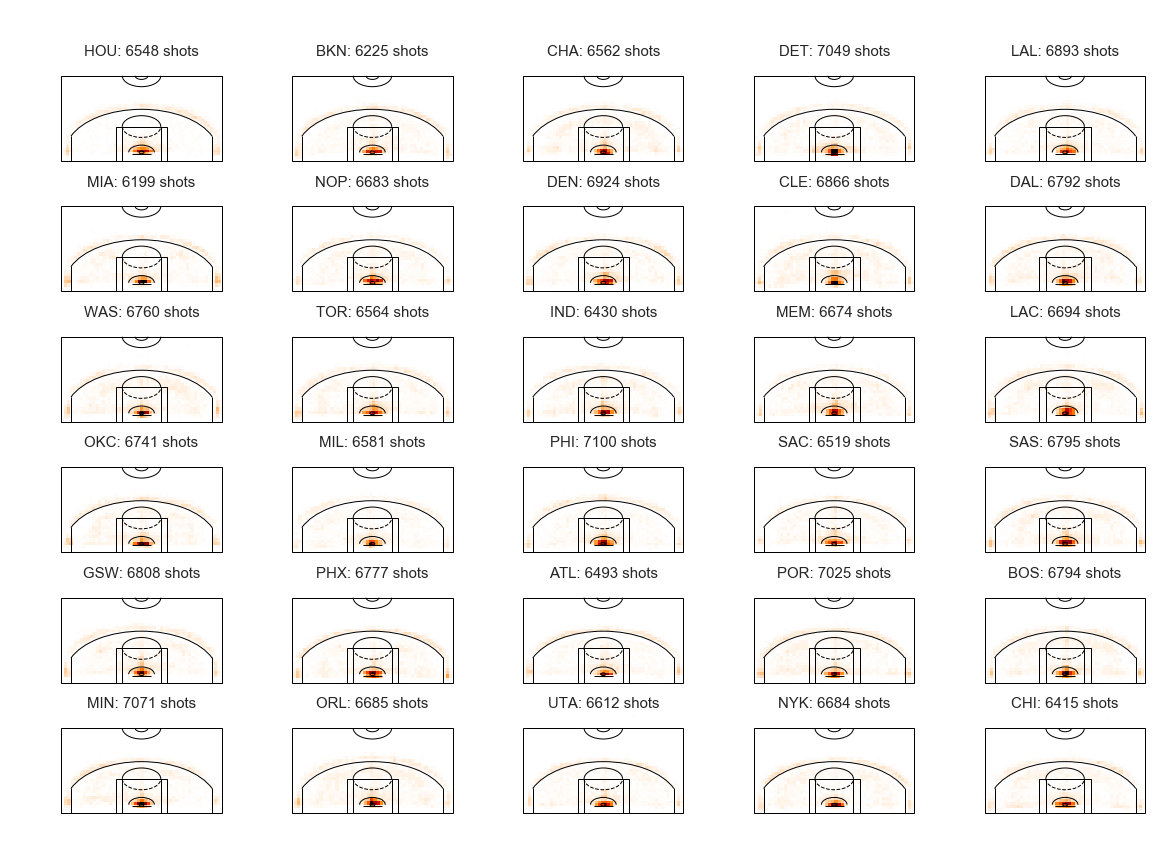

In [10]:
plt.figure(figsize=(20,14))
for i, team_abbrev in enumerate(set(df.TEAM_ABBREV)):
    plt.subplot(6, 5, i+1)
    plot_court.draw_court(outer_lines=True, lw=1.)
    
    temp = df[df.TEAM_ABBREV == team_abbrev]
    plt.hist2d(temp.LOC_X, temp.LOC_Y, bins=[50,47], cmap=plt.cm.gist_heat_r, vmax=500)
    
    plt.xlim(-300,300)
    plt.ylim(-100,500)
    plt.title('%s: %d shots'%(team_abbrev, len(temp)), fontsize=15)
    plt.axis('off')
plt.show()

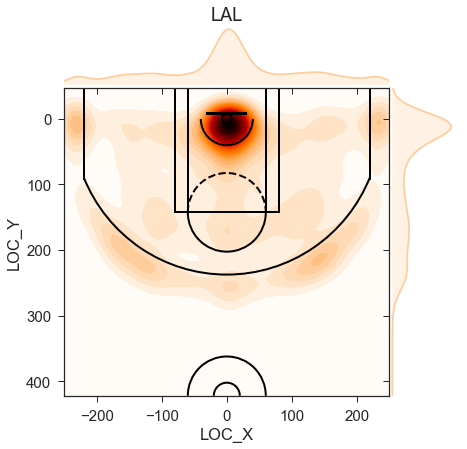

In [11]:
team_abbrev = 'LAL'
temp = df[df.TEAM_ABBREV == team_abbrev]

cmap=plt.cm.gist_heat_r
joint_shot_chart = sns.jointplot(temp.LOC_X, temp.LOC_Y, 
                                    stat_func=None,
                                    kind='kde', space=0, color=cmap(0.1),
                                    cmap=cmap, n_levels=50)
joint_shot_chart.fig.set_size_inches(7, 6.5)
ax = joint_shot_chart.ax_joint
plot_court.draw_court(ax)

ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
ax.set_title(team_abbrev, 
             y=1.2, fontsize=18)

plt.show()

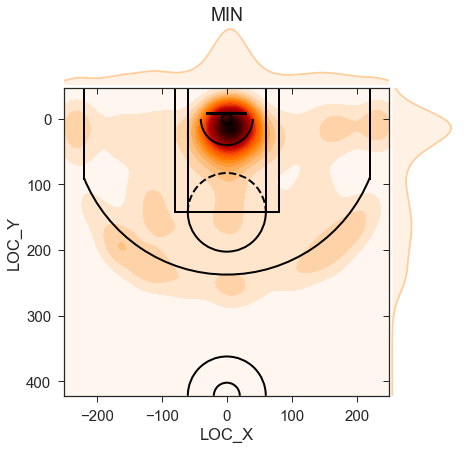

In [12]:
team_abrv = 'MIN'
temp = df[df.TEAM_ABBREV == team_abbrev]
train, test = sklearn.model_selection.train_test_split(temp, test_size = 0.2)


cmap=plt.cm.gist_heat_r
joint_shot_chart = sns.jointplot(test.LOC_X, test.LOC_Y,
                                 stat_func=None,
                                 kind='kde', space=0, color=cmap(0.1),
                                 cmap=cmap, n_levels=30)
joint_shot_chart.fig.set_size_inches(7, 6.5)
ax = joint_shot_chart.ax_joint
plot_court.draw_court(ax)

ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)
ax.set_title(team_abrv, 
             y=1.2, fontsize=18)

plt.show()

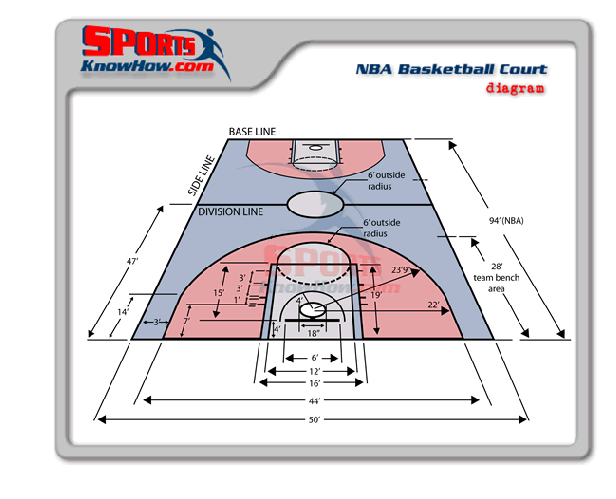

In [13]:
import urllib.request
# we pass in the link to the image as the 1st argument
# the 2nd argument tells urlretrieve what we want to scrape
pic = urllib.request.urlretrieve("http://www.sportsknowhow.com/wp-content/uploads/2015/03/basketball-NBA-court-dimensions-diagram-lrg.gif",
                                "basketball-NBA-court-dimensions-diagram-lrg.gif")

# urlretrieve returns a tuple with our image as the first 
# element and imread reads in the image as a 
# mutlidimensional numpy array so matplotlib can plot it
courtDim_pic = plt.imread(pic[0])

# plot the image
plt.figure(figsize=(10,10))
plt.imshow(courtDim_pic)
plt.axis('off')
plt.show()

In [14]:
team_abbrev = 'PHI'
temp = df[df.TEAM_ABBREV == team_abbrev]
hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(temp.LOC_X, temp.LOC_Y, 
                                                                    temp.SHOT_MADE_FLAG,
                                                                    statistic='count',
                                                                    bins=[50,47], 
                                                                    range=[[-250,250], [-47.5,422.5]])
np.max(hist2d)

344.0

In [15]:
XX, YY = np.meshgrid(xedges, yedges)
print(np.shape(XX), np.shape(hist2d.T))

(48, 51) (47, 50)


In [16]:
binX_flat = XX[:-1,:-1].flatten()
binY_flat = YY[:-1,:-1].flatten()
binXY = np.column_stack((binX_flat.T, binY_flat.T))

In [21]:
len(binX_flat)

2350

In [17]:
dist_matrix = scipy.spatial.distance_matrix(binXY, binXY)
print(dist_matrix)
np.array_equal(dist_matrix, dist_matrix.transpose())

[[   0.           10.           20.         ...,  657.6473219   664.83080554
   672.08630398]
 [  10.            0.           10.         ...,  650.53823869  657.6473219
   664.83080554]
 [  20.           10.            0.         ...,  643.50602173
   650.53823869  657.6473219 ]
 ..., 
 [ 657.6473219   650.53823869  643.50602173 ...,    0.           10.           20.        ]
 [ 664.83080554  657.6473219   650.53823869 ...,   10.            0.           10.        ]
 [ 672.08630398  664.83080554  657.6473219  ...,   20.           10.            0.        ]]


True

In [27]:
def cov_func(dist_matrix, sigma2, phi2):
    return sigma2 * np.exp(-(dist_matrix**2)/phi2)
cov_K = cov_func(dist_matrix, 1., 2*10.**2)
cov_K

array([[ 1.        ,  0.60653066,  0.13533528, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.60653066,  1.        ,  0.60653066, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.13533528,  0.60653066,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.60653066,  0.13533528],
       [ 0.        ,  0.        ,  0.        , ...,  0.60653066,
         1.        ,  0.60653066],
       [ 0.        ,  0.        ,  0.        , ...,  0.13533528,
         0.60653066,  1.        ]])

In [19]:
train_df = {}
test_df = {}
for i, team_abbrev in enumerate(set(df.TEAM_ABBREV)):  
    temp = df[df.TEAM_ABBREV == team_abbrev]
    train_df[team_abbrev], test_df[team_abbrev] = sklearn.model_selection.train_test_split(temp, test_size = 0.2)

    
teams_shotHist_train = {}
for i, team_abbrev in enumerate(set(df.TEAM_ABBREV)):  
    temp = train_df[team_abbrev]
    hist2d, xedges, yedges, binnumber = scipy.stats.binned_statistic_2d(temp.LOC_X, temp.LOC_Y, 
                                                                        temp.SHOT_MADE_FLAG,
                                                                        statistic='count',
                                                                        bins=[50,47], 
                                                                        range=[[-250,250], [-47.5,422.5]])
    teams_shotHist_train[team_abbrev] = hist2d.flatten()
teams_shotHist_train

{'ATL': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'BKN': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'BOS': array([ 0.,  0.,  1., ...,  0.,  0.,  0.]),
 'CHA': array([ 0.,  0.,  1., ...,  0.,  0.,  0.]),
 'CHI': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'CLE': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'DAL': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'DEN': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'DET': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'GSW': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'HOU': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'IND': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'LAC': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'LAL': array([ 0.,  0.,  1., ...,  0.,  0.,  0.]),
 'MEM': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'MIA': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'MIL': array([ 0.,  0.,  4., ...,  0.,  0.,  0.]),
 'MIN': array([ 0.,  0.,  1., ...,  0.,  0.,  0.]),
 'NOP': array([ 0.,  0.,  1., ...,  0.,  0.,  0.]),
 'NYK': arra

In [ ]:
lgcp_model = pm.Model()

nbins = 47 * 50
with lgcp_model:

    # Priors for unknown model parameters
    z0 = pm.Normal('z0', mu=0, sd=10)
    zn = pm.MvNormal('zn', mu=np.zeros(nbins), cov=cov_K)

    # Expected value of outcome
    mu = alpha + beta[0]*Xn_v + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [23]:
pm.distributions.multivariate.MvNormal()

TypeError: __new__() missing 1 required positional argument: 'name'

In [24]:
help(pm.MvNormal)

Help on class MvNormal in module pymc3.distributions.multivariate:

class MvNormal(pymc3.distributions.distribution.Continuous)
 |  Multivariate normal log-likelihood.
 |  
 |  .. math::
 |  
 |     f(x \mid \pi, T) =
 |         \frac{|T|^{1/2}}{(2\pi)^{1/2}}
 |         \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime} T (x-\mu) \right\}
 |  
 |  ========  ==========================
 |  Support   :math:`x \in \mathbb{R}^k`
 |  Mean      :math:`\mu`
 |  Variance  :math:`T^{-1}`
 |  ========  ==========================
 |  
 |  Parameters
 |  ----------
 |  mu : array
 |      Vector of means.
 |  cov : array, optional
 |      Covariance matrix.
 |  tau : array, optional
 |      Precision matrix.
 |  
 |  Method resolution order:
 |      MvNormal
 |      pymc3.distributions.distribution.Continuous
 |      pymc3.distributions.distribution.Distribution
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, mu, cov=None, tau=None, *args, **kwargs)
 |      Initialize self.  Se